 ALGORITMO GENETICO TRADICIONAL PARA 
LA SOLUCION DEL PROBLEMA DE LAS CIUDADES   

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [70]:
data = pd.read_excel('Ciudades.xlsx')
data.describe()

,x,y
count,20.000000,20.000000
mean,49.850000,50.950000
std,30.267709,27.496363
min,10.000000,12.000000
25%,26.500000,31.500000
50%,50.000000,54.000000
75%,77.750000,66.250000
max,99.000000,99.000000


In [71]:
data.head(5)

,Ciudad,x,y
0,A,10.0,12.0
1,B,12.0,16.0
2,C,22.0,22.0
3,D,30.0,30.0
4,E,NaN,NaN


In [72]:
data = data.dropna(axis=0, how='any', ignore_index=True)
data.head(100)


,Ciudad,x,y
0,A,10.0,12.0
1,B,12.0,16.0
2,C,22.0,22.0
3,D,30.0,30.0
4,M,12.0,32.0
5,N,16.0,42.0
6,O,28.0,56.0
7,P,28.0,12.0
8,Q,62.0,55.0
9,R,95.0,32.0


In [73]:
data.count()

Ciudad    20
x         20
y         20
dtype: int64

In [74]:
lbls = data.iloc[:,0].values
x = data.iloc[:, 1]
y = data.iloc[:, 2]
print(lbls)
print(x)
print(y)


['A' 'B' 'C' 'D' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z'
 'AA' 'AB']
0     10.0
1     12.0
2     22.0
3     30.0
4     12.0
5     16.0
6     28.0
7     28.0
8     62.0
9     95.0
10    84.0
11    64.0
12    31.0
13    55.0
14    45.0
15    57.0
16    90.0
17    77.0
18    99.0
19    80.0
Name: x, dtype: float64
0     12.0
1     16.0
2     22.0
3     30.0
4     32.0
5     42.0
6     56.0
7     12.0
8     55.0
9     32.0
10    53.0
11    36.0
12    62.0
13    70.0
14    55.0
15    91.0
16    99.0
17    65.0
18    99.0
19    80.0
Name: y, dtype: float64


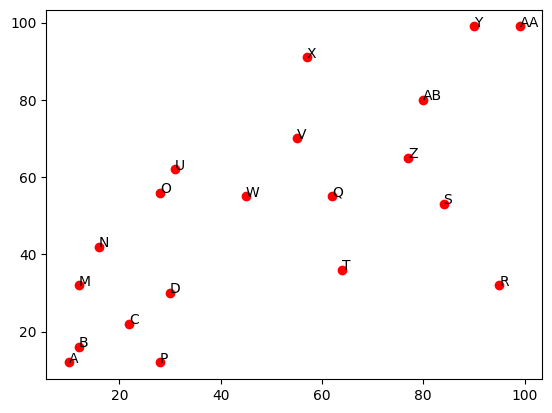

In [75]:
fig, ax = plt.subplots()
ax.plot(x,y,'ro')
for i, text in enumerate(lbls):
    #print(i)
    #print(text)
    ax.text(x[i],y[i],text)
plt.show()

# Se inicia con el desarrollo del algoritmo genetico

#### Generar poblacion aleatoria

In [114]:
def generarPoblacionAleatoria(tam_poblacion,labels):
    poblacion = []
    num_ciudades = len(lbls)
    for i in range(tam_poblacion):
        individuo = []
        while(len(individuo) <num_ciudades):
        #for j in range(num_ciudades):
            label = random.choice(labels)
            if label not in individuo:
                individuo.append(label) 
        poblacion.append(individuo)
    return poblacion

### Evaluar la poblacion

In [115]:
def fitness(poblacion,x,y):
    distancias = []
    for individuo in poblacion:
        print("individo")
        for i in range(len(individuo)):
            print(i)
        

In [117]:
poblacion = generarPoblacionAleatoria(20,lbls)
#distancias = fitness(poblacion,x,y)
print(len(poblacion))
print(len(poblacion[0]))
print(poblacion[0])

20
20
['A', 'P', 'O', 'X', 'Y', 'B', 'D', 'C', 'N', 'V', 'R', 'AA', 'Z', 'M', 'T', 'Q', 'U', 'W', 'AB', 'S']
